## **Import Libraries**

In [1]:
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import pylab
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import PIL

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## **Preparing Dataset for task 2**

**Data Preprocessing:**

In [4]:
# specify paths 
label_file = 'CelebA\Anno\identity_CelebA.txt'
img_dir = 'CelebA\Img\img_align_celeba\img_align_celeba'
output_dir = 'task2_data'

os.makedirs(output_dir, exist_ok=True)

# load labels file
data= pd.read_csv(label_file, sep=' ', header=None, names=['img', 'id'])

# mean_value of images for each label
mean_count = data['id'].value_counts().mean()

# selecting 50 unique entries having examples more than mean_count
selected_ids = [id for id,count in data['id'].value_counts().items() if count>mean_count][0:50]

# selecting 5 images for each selected_ids
new_data = pd.DataFrame(columns = ['id', 'img'])

for id in selected_ids: 
  mask = data['id'] == id
  new_data = new_data.append(data[mask][0:5])

# adding label coloumn
new_data = new_data.merge(new_data, how='cross')
new_data['label'] = new_data['id_x'] == new_data['id_y']
label_map = {True : 1, False : 0}
new_data["label"] = new_data["label"].map(label_map)

# seperating label1 and 0 data
label_1_data = new_data[new_data["label"] ==1]
label_0_data = new_data[new_data["label"] ==0]

# droping values from label 0 data so that both label 1 and 0 have equal examples
label_0_data = label_0_data[::50]

# merging label 1 and 0 data and saving a csv file 

final_data = pd.concat([label_1_data, label_0_data], ignore_index=True, sort=False)

final_data.to_csv(os.path.join(output_dir,'task2.csv'),index=False)

**Data Loading:**

In [3]:
class Custom_Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None): 
        # Run once
        self.img_labels = pd.read_csv(csv_file)
        self.transform = transform
        self.img_dir = img_dir
    
    def __len__(self):
        # return the number of samples in dataset
        return len(self.img_labels)

    def __getitem__(self, idx):
        # loads and returns a sample from the dataset at the given index
        img1_path = os.path.join(self.img_dir ,self.img_labels.iloc[idx, 1])
        img2_path = os.path.join(self.img_dir ,self.img_labels.iloc[idx, 3])
        image1 = PIL.Image.open(img1_path)
        image2 = PIL.Image.open(img2_path)
        label = torch.tensor(self.img_labels.iloc[idx, 4])
    
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        
        return image1,image2, label

In [4]:
def load_dataset(csv_file, img_dir,train_size, validation_size, test_size, batch_size):

    transform = transforms.Compose([#transforms.Grayscale(), 
                                     transforms.ToTensor(),
                                     #transforms.Resize((28,28)), 
                                     #transforms.Normalize(0,0.5)
                                     ])
    # read dataset
    dataset = Custom_Dataset(csv_file=csv_file, img_dir=img_dir, transform = transform)

    # specify sizes
    train_set_size = int(len(dataset) * train_size)
    test_set_size = int(len(dataset) * test_size)
    val_set_size = len(dataset) - train_set_size - test_set_size

    # split data
    train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_set_size,val_set_size,test_set_size])

    # create dataloader for each data (test,train,val)
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    #return test_data
    return train_data_loader, val_data_loader, test_data_loader

In [5]:
img_dir = 'CelebA\Img\img_align_celeba\img_align_celeba'
csv_file = 'task2_data/task2.csv'
train_data_loader, val_data_loader, test_data_loader = load_dataset(csv_file,img_dir,0.7,0.15,0.15, 16)

## **Creating Model**

In [6]:
from torch import nn
import torch.nn.functional as F
from torch import optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*218*178, 1000)
        self.fc2 = nn.Linear(1000, 800)
        self.fc3 = nn.Linear(800, 400)
        self.fc4 = nn.Linear(400, 200)
        self.fc5 = nn.Linear(200, 10)


    def forward(self, x, y):
        x = torch.flatten(x, 1) 
        y = torch.flatten(y, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        y = F.relu(self.fc3(y))
        y = F.relu(self.fc4(y))
        y = self.fc5(y)

        output= F.sigmoid(torch.sum(x-y,1))
        return output

# model
net = Net().to(device)

## Training Model

In [7]:
def train(epochs, train_data_loader, val_data_loader, loss_func, optimizer, learning_rate):
    train_step = len(train_data_loader)
    val_step = len(val_data_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs): # iterate over epochs
        t_loss = 0
        t_acc = 0 
        for i, data in enumerate(train_data_loader): # iterate over batches
            
          # get image and labels data is in tuple form (inputs, label)
            img1,img2, labels = data
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).float()
         
            # Zero-out gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(img1,img2)
            #pred = np.squeeze(outputs)
            pred = torch.tensor([1 if y > 0.5 else 0 for y in outputs])
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            t_acc += torch.sum(pred == labels)/len(labels)

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, epochs, i+1, train_step, loss.item()))
    
        v_loss = 0
        v_acc = 0
        for i, data in enumerate(val_data_loader): # iterate over batches
            # get image and labels data is in tuple form (inputs, label)
            img1,img2, labels = data
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).float()
            outputs = net(img1,img2)
            #pred = np.squeeze(outputs)
            pred = torch.tensor([1 if y > 0.5 else 0 for y in outputs])
            loss = loss_func(outputs, labels)
            v_loss += loss.item()
            v_acc += torch.sum(pred == labels)/len(labels)
     
        train_loss.append(t_loss/train_step)
        train_acc.append(t_acc/train_step)
        val_loss.append(v_loss/val_step)
        val_acc.append(v_acc/val_step)
        print ('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}' .format(epoch+1, epochs, train_loss[-1], val_loss[-1]))
    
    return train_loss, train_acc, val_loss, val_acc

In [36]:
# loss
criterion = nn.BCELoss()

#optimizer
learning_rate = 0.0001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#training
train_loss, train_acc, val_loss, val_acc= train(10, train_data_loader,  val_data_loader,criterion, optimizer, learning_rate)

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/10], Step [10/109], Loss: 0.6163
Epoch [1/10], Step [20/109], Loss: 0.4429
Epoch [1/10], Step [30/109], Loss: 0.6376
Epoch [1/10], Step [40/109], Loss: 0.3623
Epoch [1/10], Step [50/109], Loss: 0.5068
Epoch [1/10], Step [60/109], Loss: 0.7372
Epoch [1/10], Step [70/109], Loss: 0.5867
Epoch [1/10], Step [80/109], Loss: 0.5450
Epoch [1/10], Step [90/109], Loss: 0.9347
Epoch [1/10], Step [100/109], Loss: 0.6643
Epoch [1/10], train_loss: 0.5758, val_loss: 0.5970
Epoch [2/10], Step [10/109], Loss: 0.6525
Epoch [2/10], Step [20/109], Loss: 0.8302
Epoch [2/10], Step [30/109], Loss: 0.4629
Epoch [2/10], Step [40/109], Loss: 0.5352
Epoch [2/10], Step [50/109], Loss: 0.4298
Epoch [2/10], Step [60/109], Loss: 0.4908
Epoch [2/10], Step [70/109], Loss: 0.6873
Epoch [2/10], Step [80/109], Loss: 0.4648
Epoch [2/10], Step [90/109], Loss: 0.5395
Epoch [2/10], Step [100/109], Loss: 0.5146
Epoch [2/10], train_loss: 0.5602, val_loss: 0.6190
Epoch [3/10], Step [10/109], Loss: 0.4599
Epoch [3/10], 

## **Save Model**

In [37]:
path = 'saved_models/task2/task2.pt'
torch.save(net.state_dict(), path)

np.save('saved_models/task2/train_loss', train_loss)
np.save('saved_models/task2/val_loss', val_loss)
np.save('saved_models/task2/train_acc', train_acc)
np.save('saved_models/task2/val_acc', val_acc)

## **Test Model**

In [11]:
dataiter = iter(test_data_loader)
img1, img2, test_labels = dataiter.next()
print(test_labels)

tensor([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1])


In [12]:
# load model
net.load_state_dict(torch.load(path))
test_out = net(img1.to(device), img2.to(device))
test_out.shape
pred = torch.tensor([1 if y > 0.5 else 0 for y in test_out])
pred

tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1])

In [38]:
# load model
path = 'saved_models/task2/epoch10,lr0.0001/task2.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))

test_steps = len(test_data_loader)
t_acc=0
for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
    img1,img2, labels = data
    img1 = img1.to(device)
    img2 = img2.to(device)
    labels = labels.to(device).float()

    # forward + backward + optimize
    outputs = net(img1,img2)
    pred = torch.tensor([1 if y > 0.5 else 0 for y in outputs])
    t_acc += torch.sum(pred == labels)/len(labels)

print('Test Accuracy: {:.4f}'.format(t_acc/test_steps))

Test Accuracy: 0.6302


## **Visualize result**

Text(0.5, 1.0, 'training and validation loss')

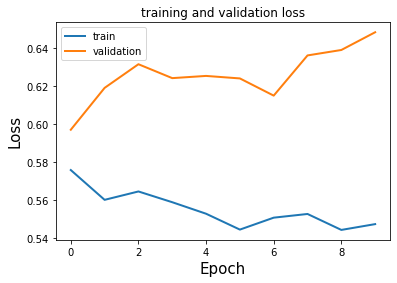

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

train_loss = np.load('saved_models/task2/epoch10,lr0.0001/train_loss.npy')
val_loss = np.load('saved_models/task2/epoch10,lr0.0001/val_loss.npy')
plt.plot(train_loss, linewidth=2, label='train')
plt.plot(val_loss, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.title('training and validation loss')

val accuracy: 0.6380208
train accuracy: 0.6754587


Text(0.5, 1.0, 'training and validation Accuracy')

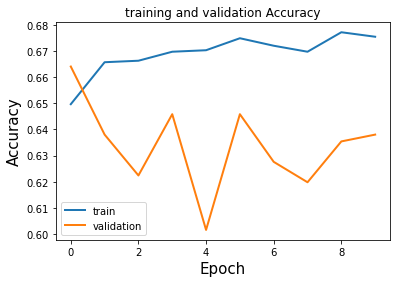

In [2]:
val_acc = np.load('saved_models/task2/epoch10,lr0.0001/val_acc.npy')
train_acc = np.load('saved_models/task2/epoch10,lr0.0001/train_acc.npy')
print('val accuracy:', val_acc[-1])
print('train accuracy:', train_acc[-1])
plt.plot(train_acc, linewidth=2, label='train')
plt.plot(val_acc, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title('training and validation Accuracy')